<a href="https://colab.research.google.com/github/rakesh4real/rollmodels/blob/main/keras2onnx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Helper Functions

In [1]:
# original source: https://github.com/onnx/keras-onnx/tree/master/tutorial
# Note: this code is compact and better compared to original


"""
## 1. Setup
"""


import matplotlib.pyplot as plt
import time
import seaborn as sns



"""
# 2. Random Image
"""


def get_and_plot_random_image_from(x_test, y_test):
    """
    """
    # get a random image index from the test set
    image_index = int(np.random.randint(0, x_test.shape[0], size=1)[0])
    expected_label = y_test[image_index]
    digit_image = x_test[image_index]
    # and plot it
    plt.title(f'Example {image_index} Label: {expected_label}')
    plt.imshow(digit_image.squeeze(2), cmap='Greys')
    plt.show()
    return digit_image, image_index



"""
# 3. Inference w/o onnx
"""


def infer_w_raw_h5(digit_image, expected_label, model, input_shape, loop_count=100):
    # reshape the image for inference/prediction
    #digit_image = digit_image.reshape(1, input_shape[0], input_shape[1], 1)
    digit_image = digit_image.reshape(1, input_shape[0], input_shape[1], input_shape[2])

    # loop `loop_count` times
    start_time = time.time()
    for i in range(loop_count):
        prediction_probabs = model.predict(digit_image)
    avg_time = ((time.time() - start_time) / loop_count)
    print(f"Keras inferences with {avg_time} second in average")

    print("="*60)
    print("Prediction probabilities:")
    print(prediction_probabs)
    print("="*60)

    predicted_label = prediction_probabs.argmax()
    print('Predicted value:', predicted_label)

    is_correct_pred = None
    if (expected_label.argmax() == predicted_label):
      print('Correct prediction')
      is_correct_pred = True
    else:
      print('Wrong prediction')
      is_correct_pred = False

    # can be used for more control (see suggestio where used)
    return (is_correct_pred, prediction_probabs), avg_time



"""
# 4. Inference w/ onnx

!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx
"""


!pip install --quiet -U onnxruntime
!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
!pip install --quiet -U git+https://github.com/onnx/keras-onnx

import onnxruntime
import keras2onnx

def h52onnx(model, output_onnxmodel_path='./onnx_model.onnx'):
  print("keras2onnx version is "+keras2onnx.__version__)
  save_name = output_onnxmodel_path.split(".onnx")[0].split("/")[-1] # get name from path
  print(save_name)
  # convert to onnx model
  onnx_model = keras2onnx.convert_keras(model, save_name, debug_mode=1)
  # and save the model in ONNX format
  keras2onnx.save_model(onnx_model, output_onnxmodel_path)


def generate_data_feed_and_sess(digit_image, input_shape, output_onnxmodel_path):
    # reshape the image for inference/prediction
    digit_image = digit_image.reshape(1, input_shape[0], input_shape[1], 1)
    
    # define session (include options using docs if necessary)
    sess_options = onnxruntime.SessionOptions()
    sess = onnxruntime.InferenceSession(output_onnxmodel_path, sess_options)
    # define data
    data = [digit_image.astype(np.float32)]
    # feed data
    input_names = sess.get_inputs()
    feed = dict([(input.name, data[n]) for n, input in enumerate(sess.get_inputs())])
    return feed, sess
    

def infer_w_onnx_runtime(digit_image, expected_label,
                         input_shape,
                         output_onnxmodel_path='./onnx_model.onnx',
                         loop_count=100):
  # setup
  feed, sess = generate_data_feed_and_sess(digit_image, input_shape, output_onnxmodel_path)

  # calculate average
  start_time = time.time()
  for i in range(loop_count):
      # note: session is used to make preds
      onnx_prediction_probabs = sess.run(None, feed)[0]
  avg_time = ((time.time() - start_time) / loop_count)
  print(f"ONNX inferences with {avg_time} second in average")

  # compare w/ raw h5
  print("="*60)
  print("[onnx]Prediction probabilities:")
  print(onnx_prediction_probabs)
  print("="*60)

  is_correct_pred = None
  print('ONNX predicted value:', onnx_prediction_probabs.argmax())
  if (expected_label.argmax() == onnx_prediction_probabs.argmax()):
    print('Correct prediction')
    is_correct_pred = True
  else:
    print('Wrong prediction')
    is_correct_pred = False

  return (is_correct_pred, onnx_prediction_probabs), avg_time

     |████████████████████████████████| 3.8MB 2.8MB/s 
     |████████████████████████████████| 7.4MB 2.6MB/s 
     |████████████████████████████████| 81kB 2.3MB/s 


# **Part 1:** Lighter Models

# Create Keras .h5 Model

- Makes sure input dims is given in first layer

In [2]:
input_shape = (28, 28, 1)

# Important while creating keras model, making inference w and w/o keras (onnx)

In [3]:
"""
## Setup
"""
import os
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow
print("TensorFlow version is "+tensorflow.__version__)


SEED = 101
from numpy.random import seed
seed(101)
import tensorflow
tensorflow.random.set_seed(101)

"""
## Prepare the data
"""

# Model / data parameters
num_classes = 10

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
# Make sure images have shape (28, 28, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")


# convert class vectors to binary class matrices
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

"""
## Build the model
"""

model = keras.Sequential(
    [
        keras.Input(shape=input_shape), # !NOTE: input shape must be defined @beg to avoid onnx errors
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

"""
## Train the model
"""

os.makedirs("keras_saved_model", exist_ok=True)
checkpoint_filepath = 'keras_saved_model/model.h5'
model_checkpoint_callback = tensorflow.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # else, error
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)



batch_size = 128
epochs = 10
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[model_checkpoint_callback])

"""
## Evaluate the trained model
"""

score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

TensorFlow version is 2.3.0
11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)     

# Load and eval best.h5 model

In [4]:
# best models
model = tensorflow.keras.models.load_model(checkpoint_filepath)

# eval
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.030320575460791588
Test accuracy: 0.9894999861717224


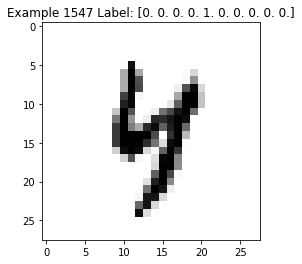

Keras inferences with 0.03954606294631958 second in average
Prediction probabilities:
[[9.5465268e-08 2.4304649e-05 2.8437185e-07 1.7355527e-05 9.9794000e-01
  3.2436950e-05 2.1096369e-06 2.4113405e-04 1.8779225e-05 1.7233961e-03]]
Predicted value: 4
Correct prediction


In [5]:
# a. get random image
digit_image, digit_idx = get_and_plot_random_image_from(x_test, y_test)

# b. loop inference for avg. inference time
(_, keras_prbs_100it), keras_time_100it = infer_w_raw_h5(digit_image, expected_label=y_test[digit_idx],
                                                              model=model, input_shape=input_shape)

# SUGGESTION: For more control, as this is for single, image, 
# Go one step further by putiing the above two functions 
# in loop as well and take average

# Conversion from Keras to ONNX


In [6]:
h52onnx(model, "./keras-mnist-optimized.onnx") # saves in curdir

tf executing eager_mode: True
tf.keras model eager_mode: False
Processing a keras layer - (dense: <class 'tensorflow.python.keras.layers.core.Dense'>)
	output: dense/Softmax_1:0
	input : dropout/cond_1/Identity:0
Processing a keras layer - (dropout: <class 'tensorflow.python.keras.layers.core.Dropout'>)
	output: dropout/cond_1/Identity:0
	input : flatten/Reshape_1:0
Processing a keras layer - (flatten: <class 'tensorflow.python.keras.layers.core.Flatten'>)
	output: flatten/Reshape_1:0
	input : max_pooling2d_1/MaxPool_1:0
Processing a keras layer - (max_pooling2d_1: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d_1/MaxPool_1:0
	input : conv2d_1/Relu_1:0
Processing a keras layer - (conv2d_1: <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>)
	output: conv2d_1/Relu_1:0
	input : max_pooling2d/MaxPool_1:0
Processing a keras layer - (max_pooling2d: <class 'tensorflow.python.keras.layers.pooling.MaxPooling2D'>)
	output: max_pooling2d/MaxPool_1

keras2onnx version is 1.7.1
keras-mnist-optimized
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense 

# Evaluate the ONNX's Model Performance

In [7]:
(_, onnxs_prbs_100it), onnx_time_100it = infer_w_onnx_runtime(digit_image, expected_label=y_test[digit_idx], 
                                                              input_shape=input_shape,
                                                              output_onnxmodel_path='./keras-mnist-optimized.onnx') # same path as used above to load

ONNX inferences with 0.0005868148803710938 second in average
[onnx]Prediction probabilities:
[[9.5465268e-08 2.4304694e-05 2.8437185e-07 1.7355558e-05 9.9794000e-01
  3.2436947e-05 2.1096446e-06 2.4113450e-04 1.8779225e-05 1.7234019e-03]]
ONNX predicted value: 4
Correct prediction


# Comaprision of inference time and model size

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


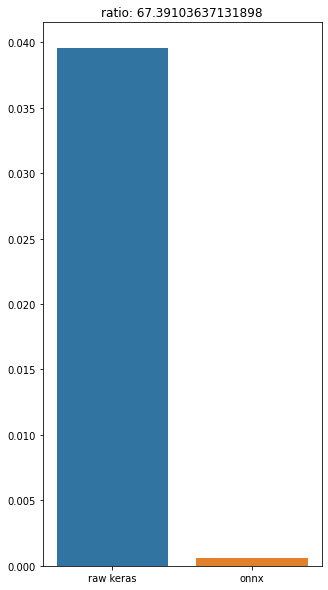

In [13]:
plt.figure(figsize=(5, 10))
sns.color_palette("husl", 8)
sns.barplot(
    ["raw keras", "onnx"],
    [keras_time_100it, onnx_time_100it],
)


plt.title(f"ratio: {keras_time_100it/onnx_time_100it}")
plt.show()

In [14]:
print(onnxs_prbs_100it)
print(keras_prbs_100it)

# Note no change in prediction probabs

[[9.5465268e-08 2.4304694e-05 2.8437185e-07 1.7355558e-05 9.9794000e-01
  3.2436947e-05 2.1096446e-06 2.4113450e-04 1.8779225e-05 1.7234019e-03]]
[[9.5465268e-08 2.4304649e-05 2.8437185e-07 1.7355527e-05 9.9794000e-01
  3.2436950e-05 2.1096369e-06 2.4113405e-04 1.8779225e-05 1.7233961e-03]]


In [15]:
def get_size(model_file_path='saved_model.pb'):
  size = os.path.getsize(model_file_path)
  return round(size/(1024.0),3)

print("Raw keras .h5 \t:", get_size('keras_saved_model/model.h5'), "KB")
print("onnx optimized \t:", get_size('keras-mnist-optimized.onnx'), "KB")

Raw keras .h5 	: 443.758 KB
onnx optimized 	: 138.607 KB


- No change in number of parameters
- No change is prediction probabilities
- Speed increased by **50 times**
- Size decreased by **3 times** 

# **Part 2:** Let's Get Heavy

- Pretrained EfficientNet

In [16]:
https://github.com/ardamavi/Dog-Cat-Classifier/blob/master/Data/Model/weights.h5

SyntaxError: ignored

In [ ]:
import numpy as np
import efficientnet.tfkeras as efn
from tensorflow.keras.applications.imagenet_utils import decode_predictions, preprocess_input
from efficientnet.preprocessing import center_crop_and_resize
from skimage.io import imread

In [ ]:
model = efn.EfficientNetB0(weights='imagenet')

In [ ]:
print(cv2.imread('cat.jpg', 1))

In [ ]:
import matplotlib.pyplot as plt
import cv2

image = cv2.imread('./cat.jpg')
print(image.shape)

image_size = model.input_shape[1]
plt.imshow(image, interpolation='nearest')
plt.show()
x = center_crop_and_resize(image, image_size=image_size)

x = preprocess_input(x, mode='torch')
inputs = np.expand_dims(x, 0)
expected = model.predict(inputs)
decode_predictions(expected)